# Notebook para manutenção do código

## Home

In [93]:
import logging
import numpy as np
import pandas as pd
from PIL import Image
import streamlit as st

In [94]:
# Extra script
uploaded_files = [
    '../data/kenji/movimentacao-2019.xlsx',
    '../data/kenji/movimentacao-2020.xlsx',
    '../data/kenji/movimentacao-2021.xlsx',
    '../data/kenji/movimentacao-2022.xlsx',
]

In [95]:
def data_ingestion(uploaded_files):
    df = pd.DataFrame()
    for i in uploaded_files:
        df_temp = pd.read_excel(i, engine='openpyxl')
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    
    df.drop_duplicates(keep='last', inplace=True)        
    return df
    
# Teste
df_data_ingestion = data_ingestion(uploaded_files)
df_data_ingestion.head(2)

c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Entrada/Saída,Data,Movimentação,Produto,Instituição,Quantidade,Preço unitário,Valor da Operação
0,Credito,17/12/2019,Transferência - Liquidação,CEBR3 - CIA ENERGETICA DE BRASILIA,MODAL DTVM LTDA,100.0,53.69,5369.0
1,Credito,17/12/2019,Transferência - Liquidação,ITSA4 - ITAUSA S/A,MODAL DTVM LTDA,100.0,13.6,1360.0


In [96]:
def data_treatment(df):
    # Datatype
    dict_dtype = {'credito_ou_debito': str,
                  'data': str,
                  'tp_movimento': str,
                  'ativo': str,
                  'instituicao': str,
                  'qt_abs': float,
                  'preco_mov': float,
                  'vl_total_abs': float}
    
    df.columns = list(dict_dtype.keys())
    df['preco_mov'].replace('-', 0, inplace=True)
    df['vl_total_abs'].replace('-', 0, inplace=True)
    df = df.astype(dict_dtype)
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')

    # (geral) Nova variável: classificação do ativo.
    df['tp_ativo'] = np.select(
        [
            (df['ativo'].str.upper()).str.contains('TESOURO'),
            df['ativo'].str.split(' - ', 0).str[0].str.len() == 5,
            df['ativo'].str.split(' - ', 0).str[0].str.len() == 6,
            df['ativo'].str.contains('DEB'),
            df['ativo'].str.contains('|'.join(['CDB', 'RDB', 'LCA', 'LCI']))
        ],
        [
            'Tipo 1: tesouro',
            'Tipo 2: ações',
            'Tipo 3: BDR',
            'Tipo 4: debêntures',
            'Tipo 5: renda fixa privada'
        ],'?'
    )

    # (geral) Nova variável: ticker.
    df['ticker'] = np.select(
        [
            df['tp_ativo'] == 'Tipo 4: debêntures',
            df['tp_ativo'] == 'Tipo 5: renda fixa privada'
        ],
        [   
            df['ativo'].str[5:12],
            df['ativo'].str[5:17]
        ], df['ativo'].str.split(' - ').str[0]
    )

    # (bolsa) Ajuste específico de ações: zerar a quantidade de compra/venda em caso de dividendos e juros sobre capital próprio.
    condition = ~df['tp_movimento'].isin(['Transferência - Liquidação', 'Bonificação em Ativos', 'Desdobro']) & \
                df['tp_ativo'].isin(['Tipo 2: ações', 'Tipo 3: BDR'])
    df['qt_abs'] = np.where(condition, 0, df['qt_abs'])

    # (geral) Nova variável: variação na quantidade de ativos.
    df['qt'] = df['qt_abs'] * np.where(df['credito_ou_debito'] == 'Credito', 1, -1)

    # (geral) Nova variável: variação na quantidade no valor total.
    df['vl_total'] = df['vl_total_abs'] * np.where(df['credito_ou_debito'] == 'Credito', 1, -1)

    # (bolsa) Nova variável: flag se a negociação é um provento (dividendo, juros sobre capital próprio ou leilão)
    df['evento'] = np.select(
        [
            df['tp_movimento'].isin(['Dividendo', 'Juros Sobre Capital Próprio', 'Fração em Ativos', 'Leilão de Fração']),
            df['tp_movimento'].isin(['Bonificação em Ativos']),
            df['tp_movimento'].isin(['Desdobro', 'Grupamento', ]),
            df['tp_movimento'].isin(['Transferência - Liquidação', 'Compra', 'Venda', 'COMPRA / VENDA', 'COMPRA/VENDA DEFINITIVA/CESSAO']),
            df['tp_movimento'].isin(['Cobrança de Taxa Semestral', 'Atualização'])
        ],
        [
            'dividendo_ou_jcp',
            'bonificacao',
            'split',
            'compra_ou_venda',
            'outros'
        ],
        '?')
    return df

# Teste
df_data_treatment = data_treatment(df_data_ingestion)
df_data_treatment.head(2)

,credito_ou_debito,data,tp_movimento,ativo,instituicao,qt_abs,preco_mov,vl_total_abs,tp_ativo,ticker,qt,vl_total,evento
0,Credito,2019-12-17,Transferência - Liquidação,CEBR3 - CIA ENERGETICA DE BRASILIA,MODAL DTVM LTDA,100.0,53.69,5369.0,Tipo 2: ações,CEBR3,100.0,5369.0,compra_ou_venda
1,Credito,2019-12-17,Transferência - Liquidação,ITSA4 - ITAUSA S/A,MODAL DTVM LTDA,100.0,13.60,1360.0,Tipo 2: ações,ITSA4,100.0,1360.0,compra_ou_venda


In [97]:
a = df_data_treatment
a.loc[a['ticker'] == 'BPAN4']

,credito_ou_debito,data,tp_movimento,ativo,instituicao,qt_abs,preco_mov,vl_total_abs,tp_ativo,ticker,qt,vl_total,evento
17,Debito,2019-11-08,Transferência - Liquidação,BPAN4 - BANCO PAN S/A,MODAL DTVM LTDA,600.0,9.33,5598.0,Tipo 2: ações,BPAN4,-600.0,-5598.0,compra_ou_venda
20,Credito,2019-11-05,Transferência - Liquidação,BPAN4 - BANCO PAN S/A,MODAL DTVM LTDA,600.0,9.17,5502.0,Tipo 2: ações,BPAN4,600.0,5502.0,compra_ou_venda


In [98]:
def only_tesouro(df):
    df = df.loc[df['tp_ativo'] == 'Tipo 1: tesouro'].sort_values(by=['ticker','data'], ascending=True)
    df = df.groupby(['tp_ativo','ticker','data']).agg({'qt':'sum', 'vl_total':'sum'}).reset_index()
    df['preco_mov'] = np.where(df['qt'] != 0, round(df['vl_total'] / df['qt'], 2), 0)
    df = df[['data', 'ticker', 'qt', 'preco_mov', 'vl_total']]
    return df

# Teste
df_tesouro = only_tesouro(df_data_treatment)
df_tesouro.head(2)

,data,ticker,qt,preco_mov,vl_total
0,2021-06-30,Tesouro IPCA+ 2035,1.7,2045.17,3476.79
1,2022-07-01,Tesouro IPCA+ 2035,0.0,0.00,-3.14


In [99]:
def only_bolsa(df):
    df = df.loc[(df['tp_ativo'] == 'Tipo 2: ações') | (df['tp_ativo'] == 'Tipo 3: BDR')].sort_values(by=['ticker','data'], ascending=True)
    df = df[['data', 'ticker', 'tp_movimento', 'evento', 'qt', 'preco_mov', 'vl_total']]
    df = df.groupby(['data', 'ticker','evento']).agg({'qt':'sum', 'vl_total':'sum'}).reset_index(drop=False)
    return df

df_bolsa = only_bolsa(df_data_treatment)
df_bolsa.head()

,data,ticker,evento,qt,vl_total
0,2019-11-05,BPAN4,compra_ou_venda,600.0,5502.0
1,2019-11-06,MGLU3,compra_ou_venda,-100.0,-4499.0
2,2019-11-08,BPAN4,compra_ou_venda,-600.0,-5598.0
3,2019-11-08,CCRO3,compra_ou_venda,300.0,5046.0
4,2019-11-12,CYRE3,compra_ou_venda,100.0,2725.0


## Tesouro Direto

In [100]:
import datetime
import pandas as pd
import yfinance as yf
from lib.history import tesouro
from lib.date import dummy_last_day_of_month_in_sample
from lib.streamlit import pivot_table, lineplot

### Parte 1: Tabela Dinâmica

In [101]:
df_tesouro.head()

,data,ticker,qt,preco_mov,vl_total
0,2021-06-30,Tesouro IPCA+ 2035,1.70,2045.17,3476.79
1,2022-07-01,Tesouro IPCA+ 2035,0.00,0.00,-3.14
2,2021-11-04,Tesouro IPCA+ 2045,3.30,1069.94,3530.80
3,2022-07-01,Tesouro IPCA+ 2045,0.00,0.00,-3.48
4,2020-07-10,Tesouro Prefixado 2023,1.63,903.07,1472.00


In [102]:
# Carregando os preços diários extraídos da API do Tesouro.
df_history_tesouro = tesouro()
df_history_tesouro.head(2)

,data,ticker,preco_hist
0,2018-11-30,Tesouro IGPM+ com Juros Semestrais 2031,6457.80
1,2018-11-30,Tesouro Selic 2023,9811.13


In [103]:
def tesouro_treatment(df_history_tesouro, df_tesouro):
    df = pd.merge(df_history_tesouro, df_tesouro, on=['data','ticker'], how='left').fillna(0).sort_values(['ticker','data']).reset_index(drop=True)

    for i in df.loc[df['qt'] > 0, 'ticker'].unique():
        df.loc[df['ticker'] == i, 'qt_acum'] = df.loc[df['ticker'] == i, 'qt'].cumsum()
        
    df = df.loc[(df['qt_acum'] > 0) | (df['qt'] != 0)].reset_index(drop=True)
    df['vl_atualizado'] = (df['qt_acum'] * df['preco_hist']).round(2)
    df['ultimo_dia_mes'] = dummy_last_day_of_month_in_sample(date_array=df['data'])

    return df


df_tesouro_treatment = tesouro_treatment(df_history_tesouro, df_tesouro)
df_tesouro_treatment.head(2)

,data,ticker,preco_hist,qt,preco_mov,vl_total,qt_acum,vl_atualizado,ultimo_dia_mes
0,2021-06-30,Tesouro IPCA+ 2035,2002.19,1.7,2045.17,3476.79,1.7,3403.72,1
1,2021-07-01,Tesouro IPCA+ 2035,2000.26,0.0,0.00,0.00,1.7,3400.44,0


In [104]:
# Selecionar os tickers a serem visualizados (desnecessário neste notebook)
'''
# Filtro de tickers.
list_ticker = st.multiselect('Escolha o(s) investimento(s):',
                                df_tesouro_historico['ticker'].unique().tolist(),
                                df_tesouro_historico['ticker'].unique().tolist())
df_tesouro_historico = df_tesouro_historico.loc[df_tesouro_historico['ticker'].isin(list_ticker)]
'''

"\n# Filtro de tickers.\nlist_ticker = st.multiselect('Escolha o(s) investimento(s):',\n                                df_tesouro_historico['ticker'].unique().tolist(),\n                                df_tesouro_historico['ticker'].unique().tolist())\ndf_tesouro_historico = df_tesouro_historico.loc[df_tesouro_historico['ticker'].isin(list_ticker)]\n"

In [105]:
#pivot_table(df=df_tesouro_treatment, x='data', y='ticker', value='vl_atualizado')

### Parte 2: Gráfico de Linha com Benchmark

In [106]:
from lib.history import tesouro, cdi, ipca, ibovespa, sp500, all_benchmarks
from lib.data_manipulation import calculate_accrued_yield

In [107]:
df_tesouro_treatment['data'].min()


df_benchmarks = all_benchmarks(start_date=df_tesouro_treatment['data'].min(),
                               end_date=df_tesouro_treatment['data'].max())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [108]:
df_tesouro_treatment.loc[0, 'data'], df_benchmarks.loc[0, 'data']

(Timestamp('2021-06-30 00:00:00'), Timestamp('2020-04-14 00:00:00'))

In [109]:
def benchmark_treatment(df_tesouro_treatment, df_benchmarks):

    list_bench = df_benchmarks.columns[1:].tolist()
    df_agg = df_tesouro_treatment.groupby(['data']).agg({'vl_total':'sum', 'vl_atualizado':'sum'}).reset_index(drop=False)
    df_agg.rename(columns={'vl_atualizado':'carteira'}, inplace=True)
    df_agg['data'] = pd.to_datetime(df_agg['data'])
    df = pd.merge(df_agg, df_benchmarks, on='data', how='left')

    for i in list_bench:
        df[i] = calculate_accrued_yield(array_value=df['vl_total'], array_yield=df[i])
        
    df = pd.melt(df, id_vars='data', value_vars=['carteira'] + list_bench[1:])
    df['data_lag'] = df['data'].shift(-1)

    return df

df_benchmark_treatment = benchmark_treatment(df_tesouro_treatment, df_benchmarks)
df_benchmark_treatment.head()

,data,variable,value,data_lag
0,2020-04-14,carteira,2959.40,2020-04-15
1,2020-04-15,carteira,2959.83,2020-04-16
2,2020-04-16,carteira,5180.45,2020-04-17
3,2020-04-17,carteira,5181.19,2020-04-20
4,2020-04-20,carteira,5181.94,2020-04-22


<AxesSubplot:xlabel='data', ylabel='value'>

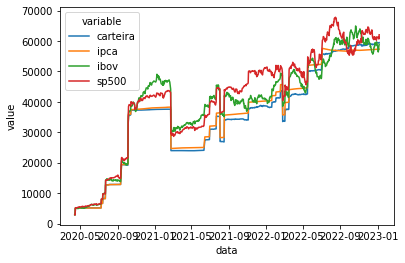

In [110]:
import seaborn as sns
sns.lineplot(data=df_benchmark_treatment, x='data', y='value', hue='variable')

In [111]:
#lineplot(df=df_benchmark_treatment, x='data', y='value', label='variable', title='teste')

### Parte 3: KPI

In [112]:
date_interval = (datetime.datetime(2022, 7, 3), datetime.datetime(2022, 12, 1))
date_interval

(datetime.datetime(2022, 7, 3, 0, 0), datetime.datetime(2022, 12, 1, 0, 0))

In [113]:
df_date = pd.DataFrame({'data': pd.date_range(df_tesouro_treatment['data'].min().to_pydatetime() - datetime.timedelta(days=1),
                                                df_tesouro_treatment['data'].max().to_pydatetime())})
df_kpi = pd.merge(df_date, df_tesouro_treatment, on='data', how='left')
df_kpi = df_kpi.groupby('data').agg({'qt':'sum', 'qt_acum':'sum',  'vl_atualizado':'sum'}).reset_index()
df_kpi['vl_atualizado'] = np.where(df_kpi['qt_acum'] != 0, df_kpi['vl_atualizado'], np.nan)
df_kpi['vl_atualizado'] = df_kpi['vl_atualizado'].fillna(method='ffill').fillna(0)
df_kpi.head()

,data,qt,qt_acum,vl_atualizado
0,2020-04-13,0.00,0.00,0.00
1,2020-04-14,0.28,0.28,2959.40
2,2020-04-15,0.00,0.28,2959.83
3,2020-04-16,0.21,0.49,5180.45
4,2020-04-17,0.00,0.49,5181.19


In [114]:
# Cálculo dos aportes históricos.
vl_aporte = df_tesouro_treatment.loc[(df_tesouro_treatment['qt'] != 0) &
                                        (df_tesouro_treatment['vl_total'] > 0) &
                                        (df_tesouro_treatment['data'] <= date_interval[1]), 'vl_total'].sum()

vl_aporte_delta = df_tesouro_treatment.loc[(df_tesouro_treatment['qt'] != 0) &
                                            (df_tesouro_treatment['vl_total'] > 0) &
                                            (df_tesouro_treatment['data'].between(date_interval[0], date_interval[1])), 'vl_total'].sum()

# Cálculo dos valores resgatados.
vl_resgate = df_tesouro_treatment.loc[(df_tesouro_treatment['qt'] != 0) &
                                        (df_tesouro_treatment['vl_total'] < 0) &
                                        (df_tesouro_treatment['data'] <= date_interval[1]), 'vl_total'].sum()

vl_resgate_delta = df_tesouro_treatment.loc[(df_tesouro_treatment['qt'] != 0) &
                                            (df_tesouro_treatment['vl_total'] < 0) &
                                            (df_tesouro_treatment['data'].between(date_interval[0], date_interval[1])), 'vl_total'].sum()

# Cálculo do valor patrimonial.
vl_patrimonio = df_kpi.loc[df_kpi['data'] == date_interval[1], 'vl_atualizado'].sum()
vl_patrimonio_delta = vl_patrimonio - df_kpi.loc[df_kpi['data'] == date_interval[0], 'vl_atualizado'].sum()

# Cálculo do rendimento.
rendimento_nominal = round((vl_patrimonio - vl_resgate - vl_aporte) / vl_aporte * 100 , 1)
if  vl_aporte_delta != 0:
    rendimento_nominal_delta = round((vl_patrimonio_delta - vl_resgate_delta - vl_aporte_delta) / vl_aporte_delta * 100 , 1)
else:
    rendimento_nominal_delta = 0

vl_aporte, vl_aporte_delta, vl_resgate, vl_resgate_delta, vl_patrimonio, vl_patrimonio_delta, rendimento_nominal, rendimento_nominal_delta

(86689.84, 5779.64, -33237.02, 0.0, 58991.38, 8434.96, 6.4, 45.9)

## Bolsa

In [115]:
import pandas as pd
import yfinance as yf
from lib.data_manipulation import calculate_accrued_yield
from lib.date import dummy_last_day_of_month_in_sample
from lib.history import bolsa, cdi, ipca, ibovespa, sp500, all_benchmarks
from lib.streamlit import pivot_table

### Parte 1: tabela dinâmica

In [116]:
df_bolsa['data'] = pd.to_datetime(df_bolsa['data'], format='%Y-%m-%d')
df_bolsa.head()

,data,ticker,evento,qt,vl_total
0,2019-11-05,BPAN4,compra_ou_venda,600.0,5502.0
1,2019-11-06,MGLU3,compra_ou_venda,-100.0,-4499.0
2,2019-11-08,BPAN4,compra_ou_venda,-600.0,-5598.0
3,2019-11-08,CCRO3,compra_ou_venda,300.0,5046.0
4,2019-11-12,CYRE3,compra_ou_venda,100.0,2725.0


In [117]:
# Passo 1: extrair dados atualizados de cada ticker.
df_history_bolsa = bolsa(list_ticker_b3=df_bolsa['ticker'].sort_values().unique(),
                           start_date=df_bolsa['data'].min(),
                           end_date=df_bolsa['data'].max())
df_history_bolsa.head()

[*********************100%***********************]  20 of 20 completed


,data,ticker,preco
0,2019-11-05,B3SA3,16.43
1,2019-11-06,B3SA3,16.30
2,2019-11-07,B3SA3,16.47
3,2019-11-08,B3SA3,16.23
4,2019-11-11,B3SA3,16.70


In [118]:
def bolsa_treatment(df_history_bolsa, df_bolsa):
    df = pd.merge(df_history_bolsa, df_bolsa, on=['data', 'ticker'], how='left').fillna(0).sort_values(['ticker', 'data'])

    # Calcular a quantidade acumulada.
    for i in df['ticker'].sort_values().unique():
        df.loc[df['ticker'] == i, 'qt_acum'] = df.loc[df['ticker'] == i, 'qt'].cumsum(skipna=True)
    
    df = df.loc[(df['qt'] != 0) | (df['qt_acum'] != 0)]

    # Identificando os splides/agrupamentos na amostra.
    df = df.sort_values(['ticker', 'data'], ascending=False)
    for i in df['ticker'].unique():
        array_event = df.loc[df['ticker'] == i, 'evento']

        # Caso 1: não tem spit.
        if len(array_event[array_event == 'split']) == 0:
            df.loc[df['ticker'] == i, 'preco_fix'] = df.loc[df['ticker'] == i, 'preco']

        # Caso 2: tem split(s).
        else:
            list_index = array_event[array_event == 'split'].index.tolist()
            for j in list_index:
                df.loc[j-1, 'multiplicador_split'] = df.loc[j, 'qt_acum'] / df.loc[j - 1, 'qt_acum']
        df.loc[df['ticker'] == i, 'multiplicador_split'] = df.loc[df['ticker'] == i, 'multiplicador_split'].fillna(0).cumsum()

    # Aplicando as correções.
    df['multiplicador_split'] = df['multiplicador_split'].replace(0, 1)
    df['preco_fix'] = df['preco'] * df['multiplicador_split']
    df['vl_atualizado_fix'] = df['preco_fix'] * df['qt_acum']
    df = df.sort_values(['ticker', 'data'], ascending=True).reset_index(drop=True)
    
    # Identificando o último dia de cada mês presente na amostra.
    df['ultimo_dia_mes'] = dummy_last_day_of_month_in_sample(df['data'])

    return df

df_bolsa_treatment = bolsa_treatment(df_history_bolsa, df_bolsa)

In [119]:

df_plot = df_bolsa_treatment.loc[df_bolsa_treatment['ultimo_dia_mes'] == 1]
#pivot_table(df=df_plot, x='data', y='ticker', value='vl_atualizado_fix')
df_plot.head()


,data,ticker,preco,evento,qt,vl_total,qt_acum,multiplicador_split,preco_fix,vl_atualizado_fix,ultimo_dia_mes
20,2020-08-31,B3SA3,19.60,0,0.0,0.0,100.0,3.0,58.80,5880.0,1
41,2020-09-30,B3SA3,18.34,0,0.0,0.0,100.0,3.0,55.02,5502.0,1
62,2020-10-30,B3SA3,17.02,0,0.0,0.0,100.0,3.0,51.06,5106.0,1
81,2020-11-30,B3SA3,18.71,0,0.0,0.0,100.0,3.0,56.13,5613.0,1
101,2020-12-30,B3SA3,20.66,0,0.0,0.0,100.0,3.0,61.98,6198.0,1


### Parte 2: benchmark

In [120]:
df_bolsa['data'].min()


df_benchmarks = all_benchmarks(start_date=df_bolsa['data'].min(),
                               end_date=df_bolsa['data'].max())

df_benchmarks.head()                               

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,data,cdi,ipca,ibov,sp500
0,2019-11-05,0.018985,0.018909,-0.138120,-0.118570
1,2019-11-06,0.018985,0.018909,-0.106039,0.070250
2,2019-11-07,0.018985,0.018909,1.149202,0.273010
3,2019-11-08,0.018985,0.018909,-1.781331,0.256068
4,2019-11-11,0.018985,0.018909,0.544463,-0.196247


In [121]:
df_bolsa_treatment.head()

,data,ticker,preco,evento,qt,vl_total,qt_acum,multiplicador_split,preco_fix,vl_atualizado_fix,ultimo_dia_mes
0,2020-08-03,B3SA3,21.30,compra_ou_venda,100.0,6474.0,100.0,3.0,63.90,6390.0,0
1,2020-08-04,B3SA3,21.07,0,0.0,0.0,100.0,3.0,63.21,6321.0,0
2,2020-08-05,B3SA3,21.17,0,0.0,0.0,100.0,3.0,63.51,6351.0,0
3,2020-08-06,B3SA3,21.35,0,0.0,0.0,100.0,3.0,64.05,6405.0,0
4,2020-08-07,B3SA3,20.85,0,0.0,0.0,100.0,3.0,62.55,6255.0,0


In [122]:
# Apenas para referência
df_bolsa_treatment.loc[0, 'data'], df_benchmarks.loc[0, 'data']

(Timestamp('2020-08-03 00:00:00'), Timestamp('2019-11-05 00:00:00'))

### Parte 3: KPI

-----------

Print melhorado!

```python
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df)
```

In [123]:
# Teste
a = ['a', 'b', 'c']
for index, value in enumerate(a):
    print(index, value)

0 a
1 b
2 c


In [124]:
a = ['a', 'b', 'c']
b = [4, 5, 6]    
for value_a, value_b in zip(a, b):
    print(value_a, value_b)

a 4
b 5
c 6
